# 1. Setup
Initializing useful libraries

In [1]:
# General import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers
from keras import Model
from keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Import classification models
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## 1.1 Let's define some helper functions

In [2]:
def plot_loss_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].plot(history.history['loss'], label='train')
    axes[0].plot(history.history['val_loss'], label='test')
    axes[0].legend()
    axes[0].title.set_text('Loss')
    axes[1].plot(history.history['accuracy'], label='train')
    axes[1].plot(history.history['val_accuracy'], label='test')
    axes[1].title.set_text('Accuracy')
    axes[1].legend()

    fig.show()
    
    
def plot_confusion_matrix(cm, target_classes):
    cm_df = pd.DataFrame(
        cm,
        index = target_classes, 
        columns = target_classes)

    figure = plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 2. Splitting the Dataset and Loading the Encoder
We'll load the encoder which was trained in the previous [notebook](https://www.kaggle.com/augustodenevreze/mines-vs-rocks-autoencoder-for-feat-extraction/). For sake of simplicity, the encoder training was done in the aforementioned notebook. Should not be the case, the model training will take hours!

We'll generate the reduced dimensionality representation of the inputs (10 inputs instead of 60) with

```X_encode = encoder.predict(X)```

In [5]:
sonar = pd.read_csv('sonar.all-data.csv', header=None)

# There is some correlation between some variables, for so the dataset is
# candidate for dimensionality reduction

X = sonar.loc[:,:59]
y = sonar.loc[:,60]
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
target_names = le.classes_

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

encoder = load_model('./encoder.h5')

# Perform Feature Extraction/Dimensionality Reduction with trained autoencoder
X_encode = encoder.predict(X)
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)
n_obs, n_inputs = X_train_encode.shape

# 3.Classical Machine Learning Models Training
We'll instatiate several Machine Learning models and train them to compare the results with a baseline.

In [6]:
models = [
    ('LogReg', LogisticRegression()),
    ('DT', tree.DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(probability=True)),
    ('GNB', GaussianNB()),
    ('XGB', XGBClassifier(verbosity=0, use_label_encoder=False))
]

target_names = le.classes_

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
results = []
names = []
model_cv_results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=1986)
    cv_result = model_selection.cross_validate(model, X_train_encode, y_train,
                                               cv=kfold, scoring=scoring)

    results.append(cv_result)
    names.append(name)

    df = pd.DataFrame(cv_result)
    df['model'] = name
    model_cv_results.append(df)

model_cv_results = pd.concat(model_cv_results, ignore_index=True)
model_cv_results.groupby(['model']).mean()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc
model,,,,,,,
DT,0.000875,0.002601,0.740642,0.753391,0.740642,0.740804,0.744946
GNB,0.000550,0.002710,0.717112,0.730589,0.717112,0.712938,0.780314
KNN,0.000472,0.005151,0.741176,0.743532,0.741176,0.734224,0.812588
LogReg,0.007577,0.003230,0.795365,0.798035,0.795365,0.795599,0.818582
RF,0.095034,0.016995,0.807308,0.817351,0.807308,0.805175,0.898594
SVM,0.003007,0.003107,0.747059,0.767286,0.747059,0.739639,0.838407
XGB,0.024915,0.007748,0.807487,0.808559,0.807487,0.806610,0.869893


# 3.1 Building the Neural Network for Binary Classification

Now it's the time to build the classification neural network and train it.

In [13]:
# Using EarlyStopper to avoid overfitting
callback = EarlyStopping(monitor='val_loss', patience=400, restore_best_weights=True)
# Model a Binary classifier
model_encoded = Sequential()
model_encoded.add(layers.Dense(8, input_dim=n_inputs, activation='relu'))
model_encoded.add(layers.Dense(5, activation='relu'))
model_encoded.add(layers.Dense(3, activation='relu'))
model_encoded.add(layers.Dense(1, activation='sigmoid'))
# Define optimizer and loss function
model_encoded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
history_encoded = model_encoded.fit(X_train_encode, y_train, epochs=1000, batch_size=n_obs,
                                    validation_data=(X_test_encode, y_test), verbose=0,
                                    callbacks=[callback])

print(f"Validation accuracy: {history_encoded.history['val_accuracy'][-1]}")

Validation accuracy: 0.8809523582458496


Now we can plot the training results with the validation set. A comment here, in this notebook and the other, we're using test and validation interchangeably. In both cases the dataset mentioned is a subset which has never been used for training. Sometimes, while dealing with classic ML algorithms the regular convention is to referto this subset as the test one (such is the name of the splitting sklearn method) but in deep learning nomenclature, the term used generally is validation. Since the testing subset is used for loss calculation during the model training.

<ipython-input-2-1eb6ec933d2b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


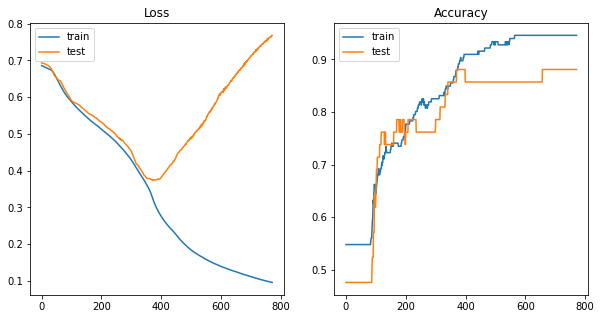

In [14]:
plot_loss_accuracy(history_encoded)

# 3.2 Comparing the Results with a not Compressed Input Representation

Now, let's train another model with the 60 non compressed inputs and compare the results. In this way, we'll see if the model accuracy is positively affected by the use of an autoencoder.

Validation accuracy: 0.738095223903656


<ipython-input-2-1eb6ec933d2b>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


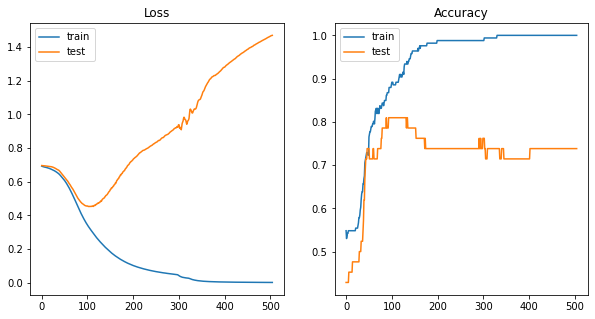

In [15]:
# Model a Binary classifier
model_standard = Sequential()
model_standard.add(layers.Dense(30, input_dim=60, activation='relu'))
model_standard.add(layers.Dense(20, activation='relu'))
model_standard.add(layers.Dense(10, activation='relu'))
model_standard.add(layers.Dense(5, activation='relu'))
model_standard.add(layers.Dense(3, activation='relu'))
model_standard.add(layers.Dense(1, activation='sigmoid'))
# Define optimizer and loss function
model_standard.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
history_standard = model_standard.fit(X_train, y_train, epochs=1000, batch_size=n_obs,
                                      validation_data=(X_test, y_test), verbose=0,
                                      callbacks=[callback])
print(f"Validation accuracy: {history_standard.history['val_accuracy'][-1]}")
plot_loss_accuracy(history_standard)

# 3.3 Confusion Matrix

Finally let's plot a confusion matrix for the compressed model to evaluate the classification results.

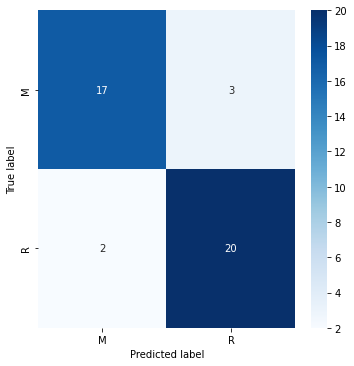

In [16]:
yhat = model_encoded.predict(X_test_encode)
# Map probablities to classes
yhat = np.where(yhat > 0.5, 1, 0)
cm = confusion_matrix(labels=y_test, predictions=yhat).numpy()
plot_confusion_matrix(cm, target_names)
